# Electrode Absorption

1.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import doModels.RefractiveIndex as ri
from collections import OrderedDict
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from shapely.geometry import LineString, Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from shapely.geometry import Polygon, box
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0, Mesh
from skfem.io import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict


2. 


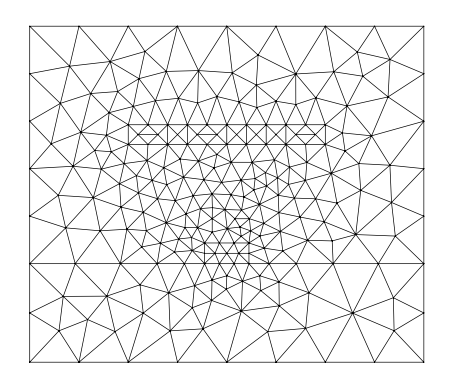

Modes(modes=(
	Mode(k: (6.177549735894596+0.4720954606369017j), n_eff:(1.5239407438286694+0.11646130556599275j))
	Mode(k: (6.167248056912366+0.4477687798488462j), n_eff:(1.5213994209738095+0.11046015274651436j))
))

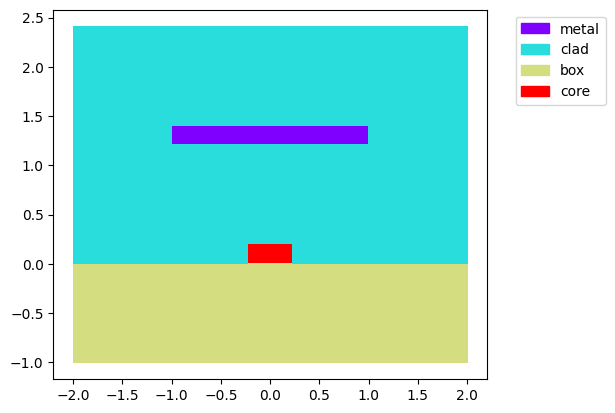

In [2]:

def plot_domains_with_legend(mesh, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_aspect(1)

    basis0 = Basis(mesh, ElementTriP0())
    subdomains = list(mesh.subdomains.keys() - {"gmsh:bounding_entities"})
    subdomain_colors = basis0.zeros() * np.nan

    for i, subdomain in enumerate(subdomains):
        subdomain_colors[basis0.get_dofs(elements=subdomain)] = i

    n_sub = len(subdomains)
    cmap = plt.get_cmap("rainbow", n_sub)
    norm = mcolors.BoundaryNorm(np.arange(n_sub + 1) - 0.5, ncolors=n_sub)
    ax = basis0.plot(subdomain_colors, plot_kwargs={"norm": norm}, ax=ax, cmap=cmap)

    legend_handles = [
        Patch(color=cmap(i), label=subdomain) for i, subdomain in enumerate(subdomains)
    ]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc="upper left")

    return ax

def mesh_waveguide(
    total_film_thickness=0.21,
    etch_depth=0.21,
    top_width=0.45,
    side_wall_angle=0,
    buffer_size=1.0,
    core_resolution=4*0.05,
    core_distance=1,
    default_resolution_max=2*0.6,
    show_plot=False,
    metal_thickness=0.2,
    metal_offset=0.5,
):
    slab_thickness = max(total_film_thickness - etch_depth, 0.0)
    bottom_width = 2 * np.tan(np.deg2rad(side_wall_angle)) + top_width
    total_slab_width = 4 + bottom_width

    if slab_thickness > 0:
        core = Polygon([
            (-total_slab_width/2, 0),
            (+total_slab_width/2, 0),
            (+total_slab_width/2, slab_thickness),
            (+bottom_width/2, slab_thickness),
            (+top_width/2, total_film_thickness),
            (-top_width/2, total_film_thickness),
            (-bottom_width/2, slab_thickness),
            (-total_slab_width/2, slab_thickness),
            (-total_slab_width/2, 0)
        ])
    else:
        core = Polygon([
            (-top_width/2, 0),
            (+top_width/2, 0),
            (+top_width/2, total_film_thickness),
            (-top_width/2, total_film_thickness),
            (-top_width/2, 0)
        ])

    polygons = OrderedDict(
        metal=box(minx=-1, maxx=1, miny=total_film_thickness+metal_offset, maxy=total_film_thickness+metal_offset+metal_thickness),
        core=core,
        box=box(minx=-2, maxx=2, miny=-1, maxy=0),
        clad=box(minx=-2, maxx=2, miny=0, maxy=total_film_thickness+metal_offset+metal_thickness+1),
    )

    resolutions = {"core": {"resolution": core_resolution, "distance": core_distance},
                   "metal": {"resolution": core_resolution, "distance": core_distance},
                   }

    mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=default_resolution_max))

    if show_plot:
        mesh.draw().show()
        plot_domains_with_legend(mesh)

    return mesh

def fem_waveguide(mesh, n_core, n_clad, n_box, n_metal, wavelength=1.55, num_modes=2, order=2, plot=False):
    basis0 = Basis(mesh, ElementTriP0())
    epsilon = basis0.zeros(dtype=complex)

    for subdomain, n in {"core": n_core(wavelength), 
                         "box": n_box(wavelength), 
                         "clad": n_clad(wavelength),
                         "metal": n_metal(wavelength)}.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes, order=order)
    if plot:
        for mode in modes:
            print(f"Effective refractive index: {mode.n_eff:.4f}")
            mode.show("E", part="real", colorbar=True)
            mode.show("E", part="imag", colorbar=True)

    return modes
    # return np.array([np.real(m.n_eff) for m in modes])


mesh = mesh_waveguide(show_plot=True, metal_offset=1)
fem_waveguide(mesh, ri.silicon_nitride, ri.silica, ri.silica, ri.titanium_nitride, plot=False)


3. 


In [3]:

offsets = np.arange(0.5, 5, 0.1)
n_effs = []

for offset in offsets:
    mesh = mesh_waveguide(metal_offset=offset)
    modes = fem_waveguide(mesh, ri.silicon, ri.silica, ri.silica, ri.titanium_nitride, plot=False)
    n_effs.append(modes[0].n_eff)


4. Visualize


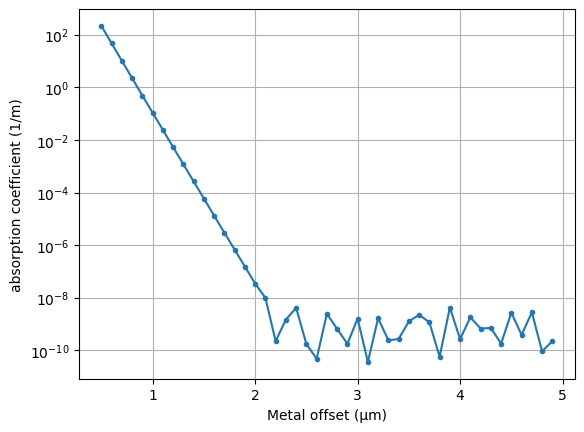

In [4]:
alpha = 4*np.pi*np.abs(np.imag(n_effs))/(1.55e-6) # [1/m]

plt.figure()
plt.semilogy(offsets, alpha, ".-")
plt.xlabel("Metal offset (µm)")
plt.ylabel("absorption coefficient (1/m)")
plt.grid()
